In [4]:
import os
from functools import partial
from itertools import product

import lightgbm as lgbm
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score

from NEExT.collections import EgonetCollection
from NEExT.io import GraphIO
from NEExT.ml_models import OutlierDataset

%reload_ext autoreload
%autoreload 2

In [5]:
from sklearn.neighbors import KNeighborsClassifier
from NEExT.experiment_utils.data_loading import initialize_graph, semi_supervised_set
from NEExT.experiment_utils.embed import build_embeddings, build_features
from NEExT.experiment_utils.models import score_unlabeled_gt
from NEExT.ml_models import CosineOutlierDetector

In [6]:
graph_io = GraphIO()
path = "../local/simulated"
name = "abcdo_data_1000_200_0.1"
frac = (1, 1)

graph_data = {
    "name": name,
    "edge_file_path": f"{path}/{name}/edges.csv",
    "node_graph_mapping_file_path": f"{path}/{name}/graph_mapping.csv",
    "features_file_path": f"{path}/{name}/features.csv",
    "skip_features": ["community_id", "random_community_feature"],
    "feature_list": [],
    "target": "is_outlier",
}
edges_df, mapping_df, features_df, ground_truth_df = initialize_graph(graph_data, frac)

In [7]:
graph_collection = graph_io.load_from_dfs(
    edges_df=edges_df,
    node_graph_df=mapping_df,
    node_features_df=features_df,
    graph_type="igraph",
)
subgraph_collection = EgonetCollection()
subgraph_collection.create_egonets_from_graphs(
    graph_collection=graph_collection,
    egonet_target=graph_data["target"],
    egonet_algorithm="k_hop_egonet",
    skip_features=graph_data["skip_features"],
    max_hop_length=1,
)
structural_features, features = build_features(subgraph_collection, feature_vector_length=3, feature_list=graph_data["feature_list"])

In [8]:
embeddings = build_embeddings(
    subgraph_collection,
    structural_features,
    features,
    strategy='structural_embedding',
    structural_embedding_dimension=13,
    feature_embedding_dimension=1,
    embedding_algorithm='sinkhornvectorizer'
)
dataset = OutlierDataset(subgraph_collection, embeddings, standardize=False)

<Axes: xlabel='emb_0_struct', ylabel='emb_1_struct'>

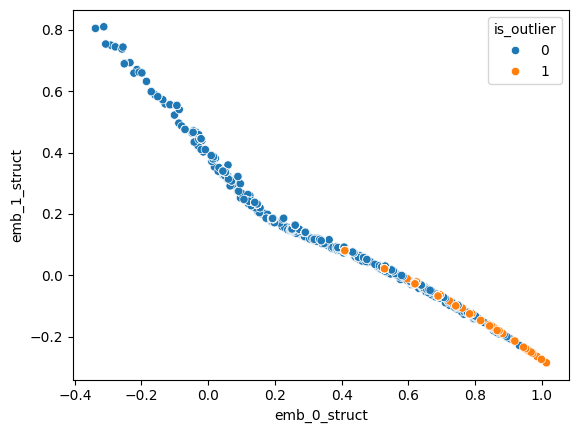

In [10]:
import seaborn as sns
sns.scatterplot(x=embeddings.embeddings_df.iloc[:, 1], y=embeddings.embeddings_df.iloc[:, 2], hue=ground_truth_df['is_outlier'])

In [11]:
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

for i in [i*10 for i in [0.1, 0.2, 0.3, 1, 5, 10, 15]]:
    scaler = StandardScaler(with_mean=False)
    detector = LocalOutlierFactor(n_neighbors=int(i))
    y_pred = detector.fit_predict(scaler.fit_transform(dataset.X_unlabeled))
    s = roc_auc_score(ground_truth_df['is_outlier'], y_pred)
    print(i, s)
for i in [i*10 for i in [0.1, 1, 5, 10, 15, 100]]:
    scaler = StandardScaler(with_mean=False)
    detector = IsolationForest(n_estimators=int(i))
    y_pred = detector.fit_predict(scaler.fit_transform(dataset.X_unlabeled))
    s = roc_auc_score(ground_truth_df['is_outlier'], y_pred)
    print(s)

/home/quak/miniconda3/envs/neext/lib/python3.11/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/home/quak/miniconda3/envs/neext/lib/python3.11/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/home/quak/miniconda3/envs/neext/lib/python3.11/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/home/quak/miniconda3/envs/neext/lib/python3.11/site-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


1.0 0.5325
2.0 0.518125
3.0 0.5199999999999999
10 0.5175
50 0.52375
100 0.54375
150 0.539375
0.604375
0.55625
0.5475
0.543125
0.551875
0.55
